<h1>
NNDL - HW2/Q2 - Ali Morajabi - 610300104
</h1>
<hr>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC, SVC

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from datetime import datetime

<h2>
Downloading and Visaulizing the Dataset
</h2>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("occultainsights/toyota-cars-over-20k-labeled-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/toyota-cars-over-20k-labeled-images


In [2]:
!ls /kaggle/input/toyota-cars-over-20k-labeled-images/toyota_image_dataset_v2/

Disclaimer  download_images_v2.py  README.txt  toyota_cars  toyota_links.csv


In [4]:
!ls /kaggle/input/toyota-cars-over-20k-labeled-images/toyota_image_dataset_v2/toyota_cars

4runner  aygo	  crown     highlander	mirai	rush	 supra	 vios
alphard  camry	  estima    hilux	previa	sequoia  tacoma  vitz
avalon	 celica   etios     innova	prius	sienna	 tundra  yaris
avanza	 corolla  fortuner  iq		rav4	soarer	 venza
avensis  corona   hiace     matrix	revo	starlet  verso


In [ ]:
root_dir = Path("/kaggle/input/toyota-cars-over-20k-labeled-images/toyota_image_dataset_v2/toyota_cars")

folder_image_counts = {}

for subfolder in root_dir.iterdir():
    if subfolder.is_dir():
        image_count = sum(1 for file in subfolder.iterdir())
        folder_image_counts[subfolder.name] = image_count

df = pd.DataFrame(list(folder_image_counts.items()), columns=['Folder', 'Image_Count'])
df_sorted = df.sort_values(by='Image_Count', ascending=False)

In [ ]:
print(df[['Folder', 'Image_Count']])

        Folder  Image_Count
0       tundra         1035
1       matrix           63
2        yaris          844
3      alphard           64
4           iq           27
5        prius         1039
6      sequoia          166
7        venza          122
8   highlander         1119
9       avalon          497
10      corona           70
11       hilux          435
12     avensis          167
13        revo          162
14      previa           44
15     starlet           48
16       crown           77
17     4runner          946
18        rav4         1786
19        rush           23
20        vios          141
21       supra          173
22    fortuner          254
23      celica          101
24       hiace           75
25      avanza           63
26      sienna          652
27       mirai           57
28      soarer           48
29      estima           32
30     corolla         2311
31        vitz          102
32      innova          121
33       verso          112
34       camry      

<h2>Data Distribution Visualization</h2>

<ipython-input-22-1b598446250e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Folder', y='Image_Count', data=df_sorted, palette='Blues_d')


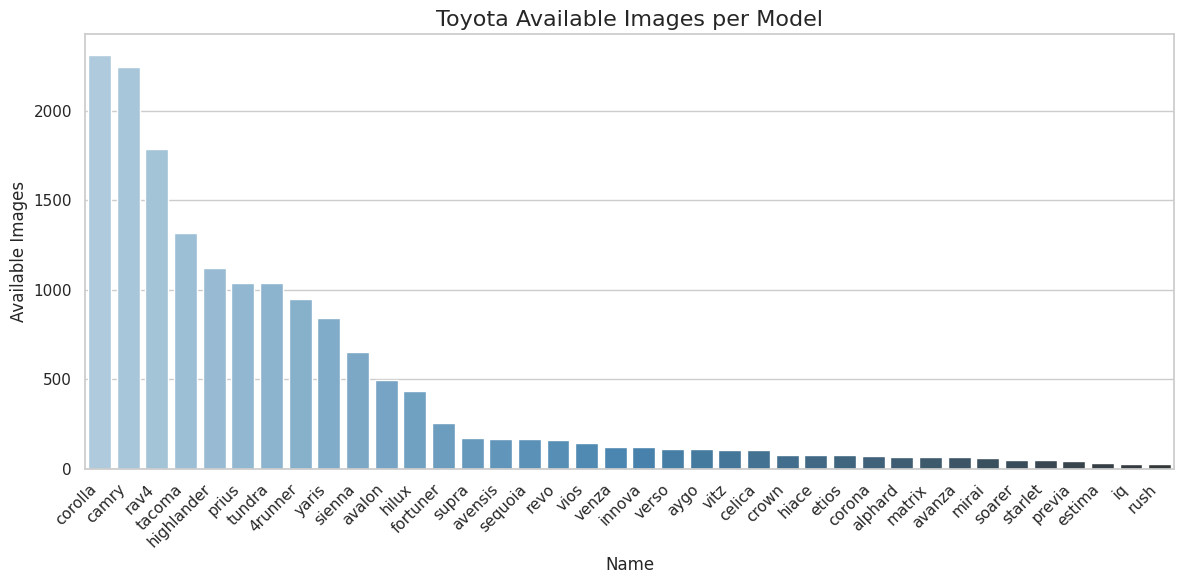

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='Folder', y='Image_Count', data=df_sorted, palette='Blues_d')

plt.title('Toyota Available Images per Model', fontsize=16)
plt.xlabel('Name', fontsize=12)
plt.ylabel('Available Images', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

<h2>Data Augmentation and Filtering Faulty Images</h2>

In [ ]:
root_dir = Path('/kaggle/input/toyota-cars-over-20k-labeled-images/toyota_image_dataset_v2/toyota_cars')
output_base_dir = Path('/kaggle/working/processed_toyota_data')

chosen_classes = {
    'corolla': 2311,
    'camry': 2246,
    'rav4': 1786,
    'tacoma': 1318,
    'highlander': 1119,
    'prius': 1039,
    'tundra': 1035,
    '4runner': 946,
    'yaris': 844,
    'sienna': 652
}
augmentation_threshold = 1500

augmentation_factor = 2

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dir = output_base_dir / 'train'
test_dir = output_base_dir / 'test'

if output_base_dir.exists():
    print(f"Cleaning up existing output directory: {output_base_dir}")
    shutil.rmtree(output_base_dir)

train_dir.mkdir(parents=True)
test_dir.mkdir()

for class_name in chosen_classes:
    (train_dir / class_name).mkdir()
    (test_dir / class_name).mkdir()

print(f"Created output directories: {train_dir} and {test_dir}")

all_image_paths = []
all_labels = []
temp_augmented_dir = output_base_dir / 'temp_augmented'
temp_augmented_dir.mkdir()

print("Starting data collection and augmentation...")

for class_name, count in chosen_classes.items():
    class_folder = root_dir / class_name
    original_image_paths = []

    for img_file in class_folder.glob('*.*'):
        if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
             original_image_paths.append(img_file)

    print(f"Found {len(original_image_paths)} original images for {class_name}.")

    all_image_paths.extend(original_image_paths)
    all_labels.extend([class_name] * len(original_image_paths))

    if count < augmentation_threshold:
        print(f"Augmenting class: {class_name} (Original Count: {count})")
        target_total_count = int(count * augmentation_factor)
        num_augmented_to_generate = max(0, target_total_count - len(original_image_paths))

        if num_augmented_to_generate > 0:
            temp_class_augment_dir = temp_augmented_dir / class_name
            temp_class_augment_dir.mkdir()

            class_images_for_augment = []
            for p in original_image_paths:
                try:
                    img = load_img(str(p), target_size=(224, 224))
                    img_array = img_to_array(img)
                    class_images_for_augment.append(img_array.astype('float32'))
                except Exception as e:
                    print(f"Could not load or process image {p} for augmentation: {e}")
                    continue

            if not class_images_for_augment:
                 print(f"No valid images loaded for augmentation in class {class_name}. Skipping augmentation.")
                 continue

            class_images_for_augment_np = np.array(class_images_for_augment)

            if len(class_images_for_augment_np.shape) == 3:
                 class_images_for_augment_np = np.expand_dims(class_images_for_augment_np, axis=-1)
                 if class_images_for_augment_np.shape[-1] == 1:
                     class_images_for_augment_np = np.repeat(class_images_for_augment_np, 3, axis=-1)


            i = 0
            print(f"Generating {num_augmented_to_generate} augmented images for {class_name}...")
            for batch in datagen.flow(
                class_images_for_augment_np,
                batch_size=1,
                save_to_dir=temp_class_augment_dir,
                save_prefix='aug',
                save_format='jpg'
            ):
                i += 1
                if i >= num_augmented_to_generate:
                    break

            print(f"Finished generating augmented images for {class_name}.")

augmented_image_paths = []
augmented_labels = []

print("Collecting paths of augmented images...")
for class_name in chosen_classes:
     temp_class_augment_dir = temp_augmented_dir / class_name
     if temp_class_augment_dir.exists():
         for aug_img_file in temp_class_augment_dir.iterdir():
              if aug_img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                  augmented_image_paths.append(aug_img_file)
                  augmented_labels.append(class_name)

print(f"Collected {len(augmented_image_paths)} augmented image paths in total.")

combined_image_paths = all_image_paths + augmented_image_paths
combined_labels = all_labels + augmented_labels

print(f"Total images for splitting (original + augmented): {len(combined_image_paths)}")

train_paths, test_paths, train_labels, test_labels = train_test_split(
    combined_image_paths,
    combined_labels,
    test_size=0.2,
    random_state=42,
    stratify=combined_labels
)

print(f"Train set size: {len(train_paths)} images")
print(f"Test set size: {len(test_paths)} images")

print("Copying images to train and test directories...")

for img_path, label in zip(train_paths, train_labels):
    dest_path = train_dir / label / img_path.name
    try:
        shutil.copy(img_path, dest_path)
    except FileNotFoundError:
        print(f"Warning: Could not find source file {img_path}. Skipping copy.")
    except Exception as e:
        print(f"Error copying {img_path} to {dest_path}: {e}")


for img_path, label in zip(test_paths, test_labels):
    dest_path = test_dir / label / img_path.name
    try:
        shutil.copy(img_path, dest_path)
    except FileNotFoundError:
        print(f"Warning: Could not find source file {img_path}. Skipping copy.")
    except Exception as e:
        print(f"Error copying {img_path} to {dest_path}: {e}")

print("Image splitting and copying complete.")
print(f"Processed data saved to: {output_base_dir}")

Created output directories: /kaggle/working/processed_toyota_data/train and /kaggle/working/processed_toyota_data/test
Starting data collection and augmentation...
Found 2311 original images for corolla.
Found 2246 original images for camry.
Found 1786 original images for rav4.
Found 1318 original images for tacoma.
Augmenting class: tacoma (Original Count: 1318)
Generating 1318 augmented images for tacoma...
Finished generating augmented images for tacoma.
Found 1119 original images for highlander.
Augmenting class: highlander (Original Count: 1119)
Generating 1119 augmented images for highlander...
Finished generating augmented images for highlander.
Found 1039 original images for prius.
Augmenting class: prius (Original Count: 1039)
Generating 1039 augmented images for prius...
Finished generating augmented images for prius.
Found 1035 original images for tundra.
Augmenting class: tundra (Original Count: 1035)
Generating 1035 augmented images for tundra...
Finished generating augmen

In [ ]:
processed_data_dir = Path('/kaggle/working/processed_toyota_data')

quarantine_dir = processed_data_dir / 'quarantine'
quarantine_dir.mkdir(exist_ok=True)

directories_to_check = [processed_data_dir / 'train', processed_data_dir / 'test']

problematic_files_count = 0

print("Checking image files and moving problematic ones to quarantine...")

for data_dir in directories_to_check:
    if not data_dir.exists():
        print(f"Directory not found: {data_dir}. Skipping.")
        continue

    print(f"\nChecking directory: {data_dir}")
    for class_folder in data_dir.iterdir():
        if class_folder.is_dir():
             (quarantine_dir / class_folder.name).mkdir(exist_ok=True)


    for class_folder in data_dir.iterdir():
        if class_folder.is_dir():
            print(f" Checking class folder: {class_folder.name}")
            quarantine_class_dir = quarantine_dir / class_folder.name

            for img_file in list(class_folder.iterdir()):
                if img_file.is_file():
                    try:
                        img = Image.open(str(img_file))
                        img.verify()
                        img.close()
                    except (IOError, UnidentifiedImageError, Exception) as e:
                        print(f"  Problematic file found: {img_file} - Error: {e}")

                        dest_path = quarantine_class_dir / img_file.name

                        try:
                            shutil.move(str(img_file), str(dest_path))
                            print(f"  Moved to quarantine: {dest_path}")
                            problematic_files_count += 1
                        except Exception as move_e:
                            print(f"  Error moving file {img_file} to quarantine: {move_e}")


print("\nFinished checking and quarantining.")

if problematic_files_count > 0:
    print(f"\n{problematic_files_count} problematic files were found and moved to '{quarantine_dir}'.")
    print("Please inspect the files in the quarantine directory.")
    print("After cleaning, you should be able to run your training code.")
else:
    print("\nNo problematic image files found.")
    print("The previous error might have been intermittent. You can try running your training code again.")

Checking image files and moving problematic ones to quarantine...

Checking directory: /kaggle/working/processed_toyota_data/train
 Checking class folder: highlander
 Checking class folder: prius
 Checking class folder: tacoma
 Checking class folder: yaris
  Problematic file found: /kaggle/working/processed_toyota_data/train/yaris/yaris-1129278736.jpg - Error: cannot identify image file '/kaggle/working/processed_toyota_data/train/yaris/yaris-1129278736.jpg'
  Moved to quarantine: /kaggle/working/processed_toyota_data/quarantine/yaris/yaris-1129278736.jpg
  Problematic file found: /kaggle/working/processed_toyota_data/train/yaris/yaris-2000577211.jpg - Error: cannot identify image file '/kaggle/working/processed_toyota_data/train/yaris/yaris-2000577211.jpg'
  Moved to quarantine: /kaggle/working/processed_toyota_data/quarantine/yaris/yaris-2000577211.jpg
 Checking class folder: tundra
 Checking class folder: rav4
 Checking class folder: corolla
  Problematic file found: /kaggle/working

<h1>VGG16</h1>

In [ ]:
image_height, image_width = 224, 224
num_classes = 10

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
image_height, image_width = 224, 224
batch_size = 32
num_classes = 10
output_base_dir = Path('/kaggle/working/processed_toyota_data')
train_dir = output_base_dir / 'train'
test_dir = output_base_dir / 'test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

print(f"Creating training data generator from: {train_dir}")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

print(f"Creating validation/test data generator from: {test_dir}")
validation_test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


num_train_samples = train_generator.samples
num_val_test_samples = validation_test_generator.samples

steps_per_epoch = num_train_samples // batch_size
if num_train_samples % batch_size != 0:
    steps_per_epoch += 1

validation_steps = num_val_test_samples // batch_size
if num_val_test_samples % batch_size != 0:
    validation_steps += 1

test_steps = validation_steps


print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation/test samples: {num_val_test_samples}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

Creating training data generator from: /kaggle/working/processed_toyota_data/train
Found 16195 images belonging to 10 classes.
Creating validation/test data generator from: /kaggle/working/processed_toyota_data/test
Found 4050 images belonging to 10 classes.
Number of training samples: 16195
Number of validation/test samples: 4050
Steps per epoch: 507
Validation steps: 127
Test steps: 127


In [ ]:
print("Starting model training...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_test_generator,
    validation_steps=validation_steps
)

print("Training finished.")

Creating training data generator from: /kaggle/working/processed_toyota_data/train
Found 16195 images belonging to 10 classes.
Creating validation/test data generator from: /kaggle/working/processed_toyota_data/test
Found 4050 images belonging to 10 classes.
Number of training samples: 16195
Number of validation/test samples: 4050
Steps per epoch: 507
Validation steps: 127
Test steps: 127
Starting model training...
Epoch 1/20
274/507 ━━━━━━━━━━━━━━━━━━━━ 1:50 476ms/step - accuracy: 0.2456 - loss: 2.2152

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


507/507 ━━━━━━━━━━━━━━━━━━━━ 284s 560ms/step - accuracy: 0.2839 - loss: 2.0673 - val_accuracy: 0.4968 - val_loss: 1.4248
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 260s 513ms/step - accuracy: 0.4589 - loss: 1.5108 - val_accuracy: 0.5635 - val_loss: 1.2746
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 258s 504ms/step - accuracy: 0.5238 - loss: 1.3602 - val_accuracy: 0.5654 - val_loss: 1.2426
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 261s 503ms/step - accuracy: 0.5656 - loss: 1.2348 - val_accuracy: 0.5360 - val_loss: 1.3610
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 255s 503ms/step - accuracy: 0.5840 - loss: 1.1818 - val_accuracy: 0.6037 - val_loss: 1.1778
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 259s 510ms/step - accuracy: 0.6122 - loss: 1.1080 - val_accuracy: 0.5941 - val_loss: 1.1707
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 254s 501ms/step - accuracy: 0.6239 - loss: 1.0668 - val_accuracy: 0.6309 - val_loss: 1.0815
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 281s 540ms/step - accuracy: 0.6337 - loss: 1.05

Evaluating model on the test set for overall metrics...
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.6598 - loss: 0.9752

Test Loss: 0.9769
Test Accuracy: 67.01%

Getting predictions and true labels for detailed metrics...
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step


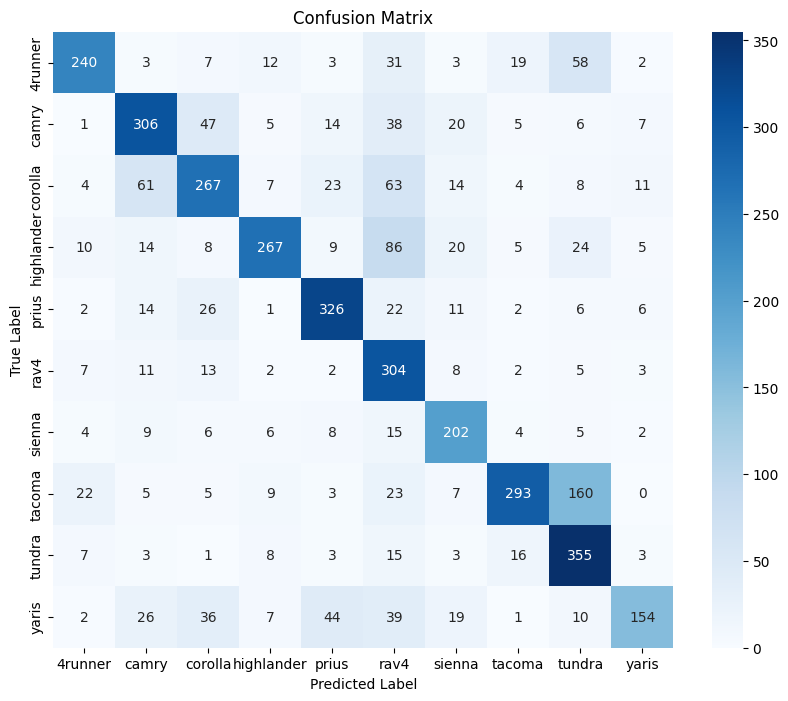

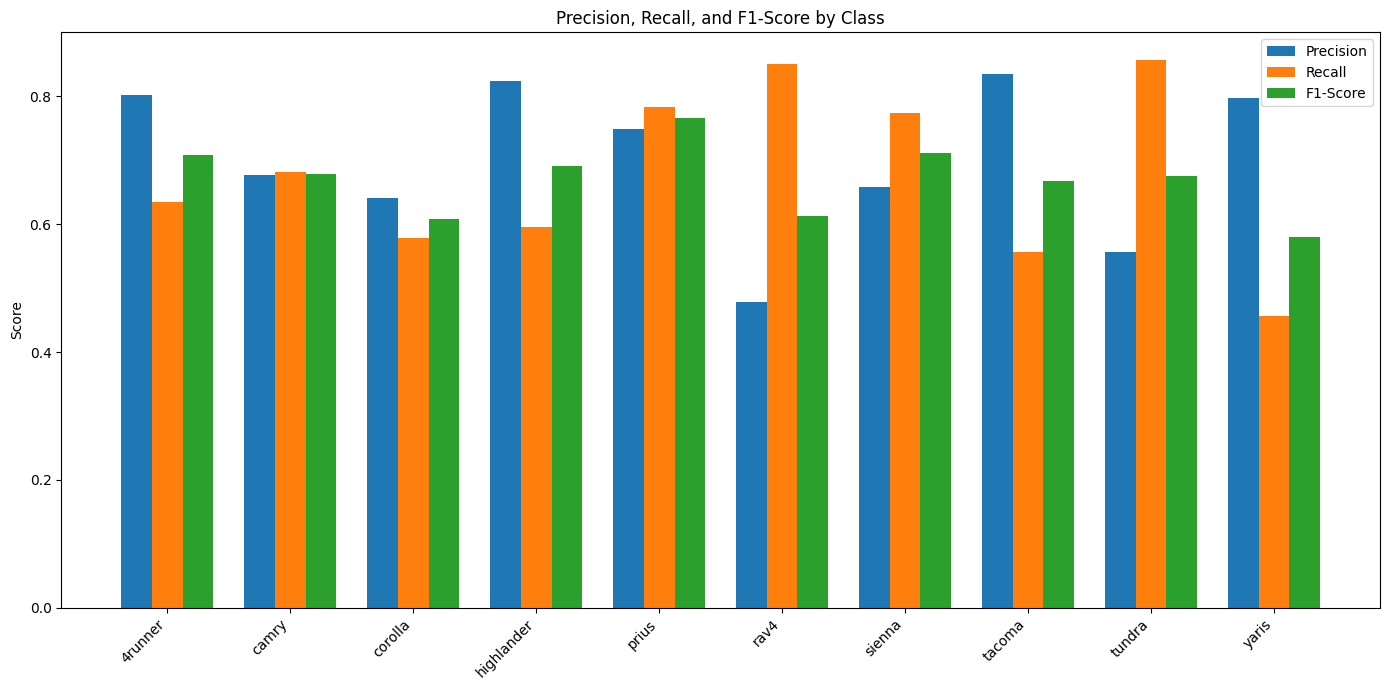


Detailed Classification Report (Text Format):
              precision    recall  f1-score   support

     4runner       0.80      0.63      0.71       378
       camry       0.68      0.68      0.68       449
     corolla       0.64      0.58      0.61       462
  highlander       0.82      0.60      0.69       448
       prius       0.75      0.78      0.77       416
        rav4       0.48      0.85      0.61       357
      sienna       0.66      0.77      0.71       261
      tacoma       0.83      0.56      0.67       527
      tundra       0.56      0.86      0.68       414
       yaris       0.80      0.46      0.58       338

    accuracy                           0.67      4050
   macro avg       0.70      0.68      0.67      4050
weighted avg       0.71      0.67      0.67      4050



In [ ]:
print("Evaluating model on the test set for overall metrics...")
test_loss, test_accuracy = model.evaluate(
    validation_test_generator,
    steps=test_steps,
    verbose=1
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

print("\nGetting predictions and true labels for detailed metrics...")

validation_test_generator.reset()

predictions = model.predict(
    validation_test_generator,
    steps=test_steps,
    verbose=1
)

true_labels = []
i = 0
for images, labels in validation_test_generator:
    true_labels.append(labels)
    i += 1
    if i >= test_steps:
        break

true_labels = np.concatenate(true_labels)

true_labels_indices = np.argmax(true_labels, axis=1)

predicted_labels_indices = np.argmax(predictions, axis=1)

class_names = list(validation_test_generator.class_indices.keys())
class_names.sort(key=lambda x: validation_test_generator.class_indices[x])


cm = confusion_matrix(true_labels_indices, predicted_labels_indices)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_labels_indices, predicted_labels_indices, target_names=class_names, output_dict=True)

classes = []
precision_scores = []
recall_scores = []
f1_scores = []

for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        classes.append(class_name)
        precision_scores.append(metrics['precision'])
        recall_scores.append(metrics['recall'])
        f1_scores.append(metrics['f1-score'])

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

rects1 = ax.bar(x - width, precision_scores, width, label='Precision')
rects2 = ax.bar(x, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width, f1_scores, width, label='F1-Score')

ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Text Format):")
print(classification_report(true_labels_indices, predicted_labels_indices, target_names=class_names))

<h1>AlexNet</h1>

In [ ]:
output_base_dir = Path('/kaggle/working/processed_toyota_data')
train_dir = output_base_dir / 'train'
val_test_dir = output_base_dir / 'test'

image_height, image_width = 224, 224
batch_size = 32

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop((image_height, image_width), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

print(f"Loading training data from: {train_dir}")
train_dataset = torchvision.datasets.ImageFolder(
    root=str(train_dir),
    transform=train_transforms
)

print(f"Loading validation/test data from: {val_test_dir}")
val_test_dataset = torchvision.datasets.ImageFolder(
    root=str(val_test_dir),
    transform=val_test_transforms
)

class_names = train_dataset.classes
print("Class names:", class_names)
num_classes = len(class_names)
print("Number of classes:", num_classes)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_test_loader = DataLoader(
    val_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation/test batches: {len(val_test_loader)}")

Loading training data from: /kaggle/working/processed_toyota_data/train
Loading validation/test data from: /kaggle/working/processed_toyota_data/test
Class names: ['4runner', 'camry', 'corolla', 'highlander', 'prius', 'rav4', 'sienna', 'tacoma', 'tundra', 'yaris']
Number of classes: 10
Number of training batches: 507
Number of validation/test batches: 127


In [ ]:
num_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

alexnet_model = models.alexnet(pretrained=True)
print("Loaded pre-trained AlexNet model.")

for param in alexnet_model.features.parameters():
    param.requires_grad = False
print("Frozen AlexNet feature layers.")

num_ftrs = alexnet_model.classifier[6].in_features

alexnet_model.classifier[6] = nn.Linear(num_ftrs, num_classes)
print(f"Modified classifier to output {num_classes} classes.")

alexnet_model = alexnet_model.to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 146MB/s]


Loaded pre-trained AlexNet model.
Frozen AlexNet feature layers.
Modified classifier to output 10 classes.


In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.classifier.parameters(), lr=0.001)

num_epochs = 20

print("Starting AlexNet model training...")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    alexnet_model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = alexnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    alexnet_model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = alexnet_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    val_loss = running_loss / len(val_test_loader.dataset)
    val_acc = running_corrects.double() / len(val_test_loader.dataset)

    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

print("AlexNet Training finished.")

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 19:19:48
Starting AlexNet model training...
Epoch 1/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0226 Acc: 0.2498
Val Loss: 1.7328 Acc: 0.3360
Epoch 2/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.8298 Acc: 0.3270
Val Loss: 1.5816 Acc: 0.3783
Epoch 3/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.7322 Acc: 0.3586
Val Loss: 1.4790 Acc: 0.4388
Epoch 4/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.6578 Acc: 0.3930
Val Loss: 1.4296 Acc: 0.4852
Epoch 5/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.6176 Acc: 0.4141
Val Loss: 1.3469 Acc: 0.5059
Epoch 6/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.5787 Acc: 0.4293
Val Loss: 1.3388 Acc: 0.5022
Epoch 7/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.5415 Acc: 0.4458
Val Loss: 1.3327 Acc: 0.5101
Epoch 8/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.4992 Acc: 0.4571
Val Loss: 1.2937 Acc: 0.5294
Epoch 9/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.4656 Acc: 0.4753
Val Loss: 1.2366 Acc: 0.5536
Epoch 10/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.4429 Acc: 0.4842
Val Loss: 1.3394 Acc: 0.4901
Epoch 11/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.4170 Acc: 0.4943
Val Loss: 1.1986 Acc: 0.5664
Epoch 12/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.3957 Acc: 0.5052
Val Loss: 1.1772 Acc: 0.5760
Epoch 13/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.3722 Acc: 0.5101
Val Loss: 1.1480 Acc: 0.5820
Epoch 14/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.3489 Acc: 0.5276
Val Loss: 1.1708 Acc: 0.5728
Epoch 15/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.3328 Acc: 0.5290
Val Loss: 1.1383 Acc: 0.5938
Epoch 16/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.3073 Acc: 0.5385
Val Loss: 1.1156 Acc: 0.6111
Epoch 17/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.2987 Acc: 0.5445
Val Loss: 1.1328 Acc: 0.6027
Epoch 18/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.2730 Acc: 0.5502
Val Loss: 1.0819 Acc: 0.6072
Epoch 19/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.2488 Acc: 0.5617
Val Loss: 1.0733 Acc: 0.6160
Epoch 20/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.2351 Acc: 0.5691
Val Loss: 1.0780 Acc: 0.6309
AlexNet Training finished.
Current Time = 20:00:16


Evaluating AlexNet model on the test set...


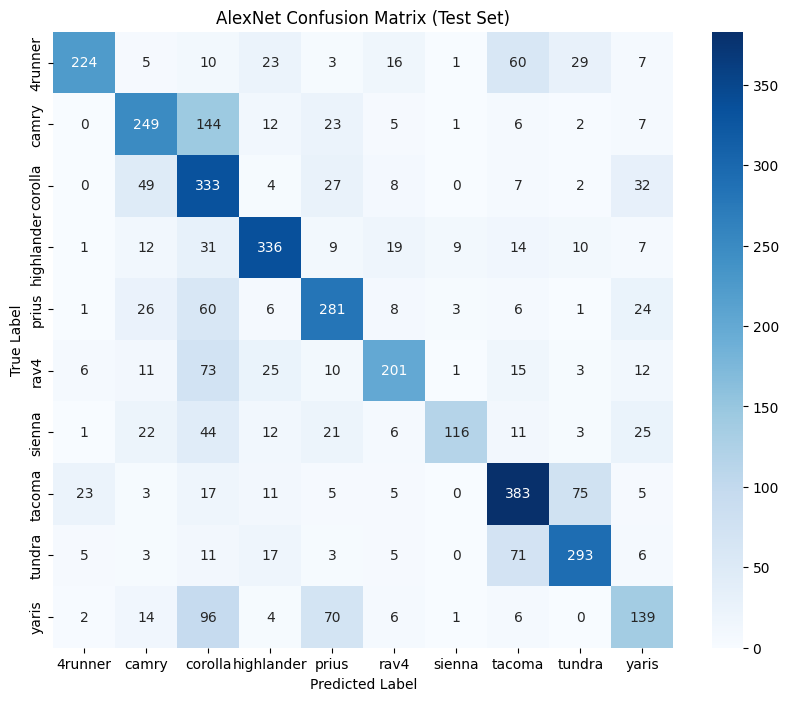

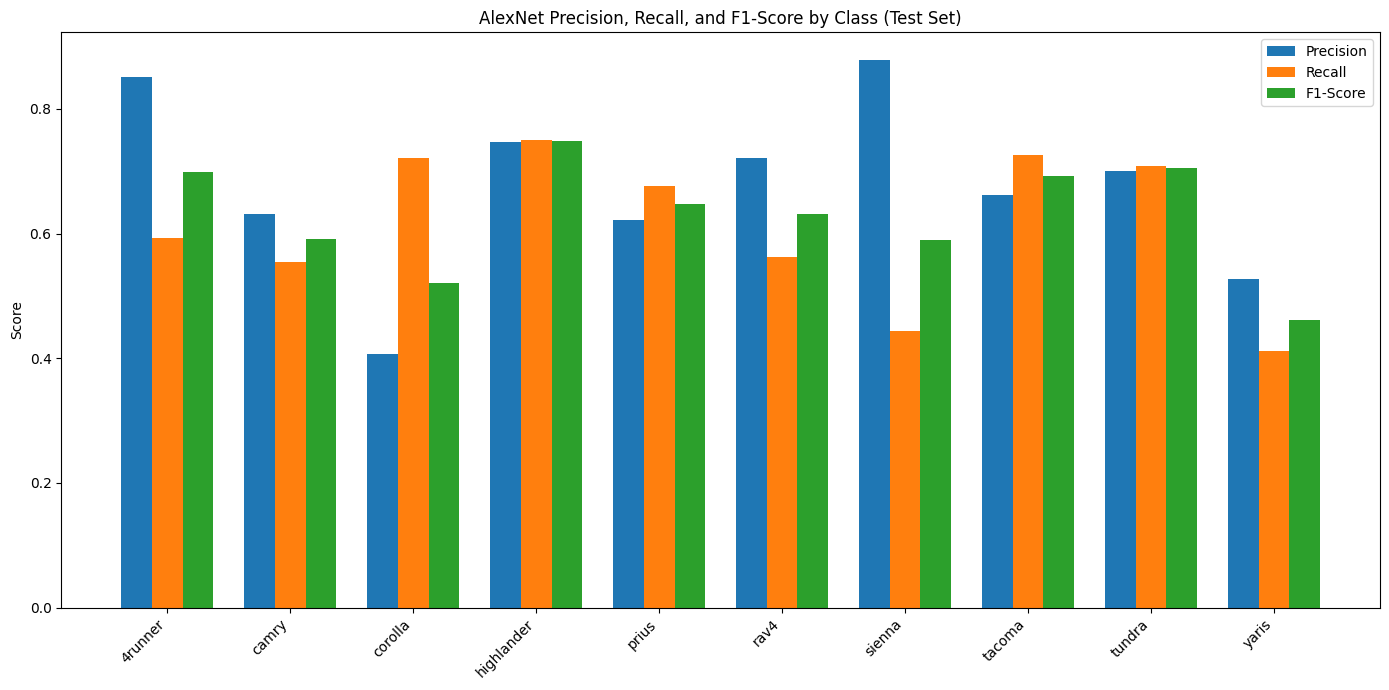


AlexNet Detailed Classification Report (Text Format, Test Set):
              precision    recall  f1-score   support

     4runner       0.85      0.59      0.70       378
       camry       0.63      0.55      0.59       449
     corolla       0.41      0.72      0.52       462
  highlander       0.75      0.75      0.75       448
       prius       0.62      0.68      0.65       416
        rav4       0.72      0.56      0.63       357
      sienna       0.88      0.44      0.59       261
      tacoma       0.66      0.73      0.69       527
      tundra       0.70      0.71      0.70       414
       yaris       0.53      0.41      0.46       338

    accuracy                           0.63      4050
   macro avg       0.67      0.61      0.63      4050
weighted avg       0.66      0.63      0.63      4050



In [ ]:
print("Evaluating AlexNet model on the test set...")

alexnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = alexnet_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


alexnet_cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(alexnet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AlexNet Confusion Matrix (Test Set)')
plt.show()

report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

classes_alexnet = []
precision_scores_alexnet = []
recall_scores_alexnet = []
f1_scores_alexnet = []

for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        classes_alexnet.append(class_name)
        precision_scores_alexnet.append(metrics['precision'])
        recall_scores_alexnet.append(metrics['recall'])
        f1_scores_alexnet.append(metrics['f1-score'])

x_alexnet = np.arange(len(classes_alexnet))
width_alexnet = 0.25

fig_alexnet, ax_alexnet = plt.subplots(figsize=(14, 7))

rects1_alexnet = ax_alexnet.bar(x_alexnet - width_alexnet, precision_scores_alexnet, width_alexnet, label='Precision')
rects2_alexnet = ax_alexnet.bar(x_alexnet, recall_scores_alexnet, width_alexnet, label='Recall')
rects3_alexnet = ax_alexnet.bar(x_alexnet + width_alexnet, f1_scores_alexnet, width_alexnet, label='F1-Score')

ax_alexnet.set_ylabel('Score')
ax_alexnet.set_title('AlexNet Precision, Recall, and F1-Score by Class (Test Set)')
ax_alexnet.set_xticks(x_alexnet)
ax_alexnet.set_xticklabels(classes_alexnet, rotation=45, ha="right")
ax_alexnet.legend()

plt.tight_layout()
plt.show()

print("\nAlexNet Detailed Classification Report (Text Format, Test Set):")
print(classification_report(all_labels, all_preds, target_names=class_names))

<h1>CNN</h1>

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

image_height, image_width = 224, 224
num_classes = 10
learning_rate = 0.001

simple_cnn_model = Sequential([
    InputLayer(input_shape=(image_height, image_width, 3)),

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(units=128, activation='relu'),
    Dropout(0.5),

    Dense(units=num_classes, activation='softmax')
])

simple_cnn_model.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

print("Simple CNN Model Summary:")
simple_cnn_model.summary()

Num GPUs Available:  1
Using GPU


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Simple CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,722 (49.36 MB)

 Trainable params: 12,939,722 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
image_height, image_width = 224, 224
batch_size = 32
num_classes = 10
output_base_dir = Path('/kaggle/working/processed_toyota_data')
train_dir = output_base_dir / 'train'
val_test_dir = output_base_dir / 'test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

print(f"Creating training data generator from: {train_dir}")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

print(f"Creating validation/test data generator from: {val_test_dir}")
validation_test_generator = val_test_datagen.flow_from_directory(
    val_test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
class_names.sort(key=lambda x: train_generator.class_indices[x])
print("Class names in order:", class_names)

num_train_samples = train_generator.samples
num_val_test_samples = validation_test_generator.samples

steps_per_epoch = num_train_samples // batch_size
if num_train_samples % batch_size != 0:
    steps_per_epoch += 1

validation_steps = num_val_test_samples // batch_size
if num_val_test_samples % batch_size != 0:
    validation_steps += 1

test_steps = validation_steps

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation/test samples: {num_val_test_samples}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

Creating training data generator from: /kaggle/working/processed_toyota_data/train
Found 16195 images belonging to 10 classes.
Creating validation/test data generator from: /kaggle/working/processed_toyota_data/test
Found 4050 images belonging to 10 classes.
Class names in order: ['4runner', 'camry', 'corolla', 'highlander', 'prius', 'rav4', 'sienna', 'tacoma', 'tundra', 'yaris']
Number of training samples: 16195
Number of validation/test samples: 4050
Steps per epoch: 507
Validation steps: 127
Test steps: 127


In [ ]:
print("Starting Simple CNN model training...")
epochs_to_train = 30

simple_cnn_history = simple_cnn_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_to_train,
    validation_data=validation_test_generator,
    validation_steps=validation_steps
)

print("Simple CNN Training finished.")=

Starting Simple CNN model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
454/507 ━━━━━━━━━━━━━━━━━━━━ 25s 479ms/step - accuracy: 0.1163 - loss: 2.4208

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


507/507 ━━━━━━━━━━━━━━━━━━━━ 268s 514ms/step - accuracy: 0.1171 - loss: 2.4095 - val_accuracy: 0.1358 - val_loss: 2.2791
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 248s 490ms/step - accuracy: 0.1418 - loss: 2.2717 - val_accuracy: 0.1857 - val_loss: 2.2196
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 242s 477ms/step - accuracy: 0.1711 - loss: 2.2261 - val_accuracy: 0.2326 - val_loss: 2.1138
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 231s 456ms/step - accuracy: 0.1913 - loss: 2.1650 - val_accuracy: 0.2588 - val_loss: 2.0283
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 272s 476ms/step - accuracy: 0.2158 - loss: 2.0977 - val_accuracy: 0.2672 - val_loss: 1.9812
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 254s 460ms/step - accuracy: 0.2388 - loss: 2.0504 - val_accuracy: 0.2706 - val_loss: 1.9757
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 261s 458ms/step - accuracy: 0.2487 - loss: 2.0187 - val_accuracy: 0.2793 - val_loss: 1.9619
Epoch 8/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 231s 456ms/step - accuracy: 0.2662 - loss: 1.99


Evaluating Simple CNN model on the test set for overall metrics...
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.4684 - loss: 1.4388

Simple CNN Test Loss: 1.4910
Simple CNN Test Accuracy: 45.98%

Getting predictions and true labels for Simple CNN detailed metrics...
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step


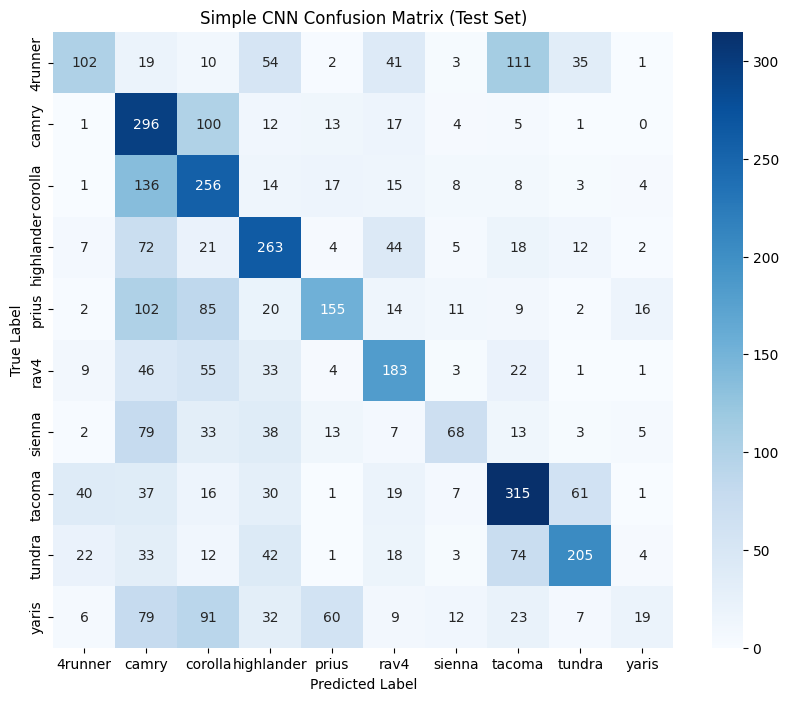

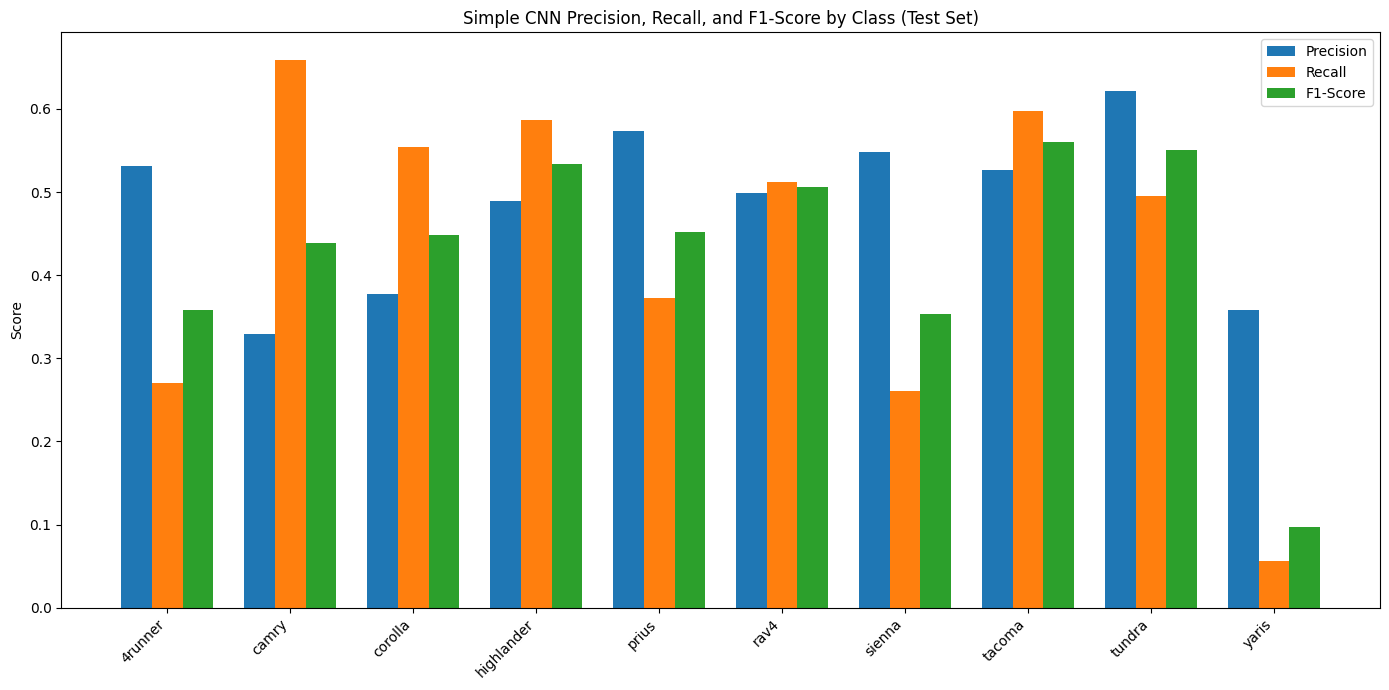


Simple CNN Detailed Classification Report (Text Format, Test Set):
              precision    recall  f1-score   support

     4runner       0.53      0.27      0.36       378
       camry       0.33      0.66      0.44       449
     corolla       0.38      0.55      0.45       462
  highlander       0.49      0.59      0.53       448
       prius       0.57      0.37      0.45       416
        rav4       0.50      0.51      0.51       357
      sienna       0.55      0.26      0.35       261
      tacoma       0.53      0.60      0.56       527
      tundra       0.62      0.50      0.55       414
       yaris       0.36      0.06      0.10       338

    accuracy                           0.46      4050
   macro avg       0.49      0.44      0.43      4050
weighted avg       0.48      0.46      0.44      4050



In [ ]:
print("\nEvaluating Simple CNN model on the test set for overall metrics...")
simple_cnn_test_loss, simple_cnn_test_accuracy = simple_cnn_model.evaluate(
    validation_test_generator,
    steps=test_steps,
    verbose=1
)

print(f"\nSimple CNN Test Loss: {simple_cnn_test_loss:.4f}")
print(f"Simple CNN Test Accuracy: {simple_cnn_test_accuracy*100:.2f}%")

print("\nGetting predictions and true labels for Simple CNN detailed metrics...")

validation_test_generator.reset()

simple_cnn_predictions = simple_cnn_model.predict(
    validation_test_generator,
    steps=test_steps,
    verbose=1
)

true_labels = []
i = 0
for images, labels in validation_test_generator:
    true_labels.append(labels)
    i += 1
    if i >= test_steps:
        break

true_labels = np.concatenate(true_labels)
true_labels_indices = np.argmax(true_labels, axis=1)

simple_cnn_predicted_labels_indices = np.argmax(simple_cnn_predictions, axis=1)


simple_cnn_cm = confusion_matrix(true_labels_indices, simple_cnn_predicted_labels_indices)

plt.figure(figsize=(10, 8))
sns.heatmap(simple_cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Simple CNN Confusion Matrix (Test Set)')
plt.show()

simple_cnn_report = classification_report(true_labels_indices, simple_cnn_predicted_labels_indices, target_names=class_names, output_dict=True)

classes_simple_cnn = []
precision_scores_simple_cnn = []
recall_scores_simple_cnn = []
f1_scores_simple_cnn = []

for class_name, metrics in simple_cnn_report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        classes_simple_cnn.append(class_name)
        precision_scores_simple_cnn.append(metrics['precision'])
        recall_scores_simple_cnn.append(metrics['recall'])
        f1_scores_simple_cnn.append(metrics['f1-score'])

# Create bar charts for precision, recall, and F1-score
x_simple_cnn = np.arange(len(classes_simple_cnn))
width_simple_cnn = 0.25

fig_simple_cnn, ax_simple_cnn = plt.subplots(figsize=(14, 7))

rects1_simple_cnn = ax_simple_cnn.bar(x_simple_cnn - width_simple_cnn, precision_scores_simple_cnn, width_simple_cnn, label='Precision')
rects2_simple_cnn = ax_simple_cnn.bar(x_simple_cnn, recall_scores_simple_cnn, width_simple_cnn, label='Recall')
rects3_simple_cnn = ax_simple_cnn.bar(x_simple_cnn + width_simple_cnn, f1_scores_simple_cnn, width_simple_cnn, label='F1-Score')

ax_simple_cnn.set_ylabel('Score')
ax_simple_cnn.set_title('Simple CNN Precision, Recall, and F1-Score by Class (Test Set)')
ax_simple_cnn.set_xticks(x_simple_cnn)
ax_simple_cnn.set_xticklabels(classes_simple_cnn, rotation=45, ha="right")
ax_simple_cnn.legend()

plt.tight_layout()
plt.show()

# --- Print Classification Report ---
print("\nSimple CNN Detailed Classification Report (Text Format, Test Set):")
print(classification_report(true_labels_indices, simple_cnn_predicted_labels_indices, target_names=class_names))

<h1>VGG16 + SVM</h1>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
print("Drive unmounted. Re-mounting...")
drive.mount('/gdrive')
print(os.listdir('/gdrive/My Drive/')) # Check again after remounting

Drive not mounted, so nothing to flush and unmount.
Drive unmounted. Re-mounting...
Mounted at /gdrive
['tree.html', 'Untitled Diagram.drawio', 'TreeOfCV.drawio', 'project-meeting.mp4', 'Bp-prj-present-time.gsheet', 'Colab Notebooks', 'YourDataSetName_Features']


In [ ]:
image_height, image_width = 224, 224
input_tensor = Input(shape=(image_height, image_width, 3))
vgg16_feature_extractor = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

print("VGG16 Feature Extractor Model Loaded.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 Feature Extractor Model Loaded.


In [ ]:
drive_base_dir = Path('/gdrive/My Drive/YourDataSetName_Features')
features_output_dir = drive_base_dir / 'vgg16_extracted_features'
features_output_dir.mkdir(parents=True, exist_ok=True)

train_features_path = features_output_dir / 'train_vgg16_features.npy'
train_labels_path = features_output_dir / 'train_labels.npy'
test_features_path = features_output_dir / 'test_vgg16_features.npy'
test_labels_path = features_output_dir / 'test_labels.npy'


print("Extracting features using VGG16...")

print("Extracting features for training data...")
train_features = []
train_labels_extracted = []

train_generator.reset()

for i in range(steps_per_epoch):
    images, labels = next(train_generator)
    features_batch = vgg16_feature_extractor.predict(images, verbose=0)
    features_batch_flattened = features_batch.reshape(features_batch.shape[0], -1)

    train_features.append(features_batch_flattened)
    train_labels_extracted.append(labels)

train_features = np.concatenate(train_features)
train_labels_extracted = np.concatenate(train_labels_extracted)
train_labels_indices = np.argmax(train_labels_extracted, axis=1)

print(f"Extracted {train_features.shape[0]} features for training data.")

# --- Save Training Features and Labels ---
print(f"Saving training features and labels to {features_output_dir}...")
np.save(train_features_path, train_features)
np.save(train_labels_path, train_labels_indices)
print("Training features and labels saved.")
print(f"Train Features saved to: {train_features_path}")
print(f"Train Labels saved to: {train_labels_path}")


# --- Extract Features for Test Data ---
print("\nExtracting features for test data...")
test_features = []
test_labels_extracted = []

validation_test_generator.reset()

# Iterate through test data generator
for i in range(test_steps):
    images, labels = next(validation_test_generator)
    features_batch = vgg16_feature_extractor.predict(images, verbose=0)
    features_batch_flattened = features_batch.reshape(features_batch.shape[0], -1)

    test_features.append(features_batch_flattened)
    test_labels_extracted.append(labels)

test_features = np.concatenate(test_features)
test_labels_extracted = np.concatenate(test_labels_extracted)
test_labels_indices = np.argmax(test_labels_extracted, axis=1)

print(f"Extracted {test_features.shape[0]} features for test data.")

# --- Save Test Features and Labels ---
print(f"Saving test features and labels to {features_output_dir}...")
np.save(test_features_path, test_features)
np.save(test_labels_path, test_labels_indices)
print("Test features and labels saved.")
print(f"Test Features saved to: {test_features_path}")
print(f"Test Labels saved to: {test_labels_path}")

print("\nFeature extraction and saving complete.")

Extracting features using VGG16...
Extracting features for training data...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
from google.colab import drive

drive.mount('/gdrive')

print("Google Drive re-mounted at /gdrive")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Google Drive re-mounted at /gdrive


In [ ]:
output_base_dir = Path('/gdrive/My Drive/YourDataSetName_Features')
features_output_dir = output_base_dir / 'vgg16_extracted_features'

train_features_path = features_output_dir / 'train_vgg16_features.npy'
train_labels_path = features_output_dir / 'train_labels.npy'
test_features_path = features_output_dir / 'test_vgg16_features.npy'
test_labels_path = features_output_dir / 'test_labels.npy'

print("Loading features and labels from disk...")

if not all([train_features_path.exists(), train_labels_path.exists(),
            test_features_path.exists(), test_labels_path.exists()]):
    print("Error: Feature files not found. Please ensure the paths are correct and the extraction block was run successfully in a previous session.")
    print(f"Looking for files in: {features_output_dir}")
    if features_output_dir.exists():
         print(f"Contents of {features_output_dir}: {list(features_output_dir.iterdir())}")
    else:
         print(f"Directory {features_output_dir} does not exist.")
else:
    try:
        train_features = np.load(train_features_path)
        train_labels_indices = np.load(train_labels_path)
        test_features = np.load(test_features_path)
        test_labels_indices = np.load(test_labels_path)

        print("Features and labels loaded successfully.")
        print(f"Loaded Train Features Shape: {train_features.shape}")
        print(f"Loaded Train Labels Shape: {train_labels_indices.shape}")
        print(f"Loaded Test Features Shape: {test_features.shape}")
        print(f"Loaded Test Labels Shape: {test_labels_indices.shape}")

    except Exception as e:
        print(f"An error occurred while loading the files: {e}")

Loading features and labels from disk...
Features and labels loaded successfully.
Loaded Train Features Shape: (16195, 25088)
Loaded Train Labels Shape: (16195,)
Loaded Test Features Shape: (4050, 25088)
Loaded Test Labels Shape: (4050,)


In [ ]:
class_names = ['4runner', 'camry', 'rav4', 'tacoma', 'highlander',
                   'prius', 'tundra', 'corolla', 'yaris', 'sienna']
class_names.sort()
print("class_names defined:", class_names)

class_names defined: ['4runner', 'camry', 'corolla', 'highlander', 'prius', 'rav4', 'sienna', 'tacoma', 'tundra', 'yaris']


In [ ]:
print("\nTraining SVM model on loaded features...")

svm_classifier = LinearSVC(random_state=42, max_iter=1000)
svm_classifier.fit(train_features, train_labels_indices)

print("SVM model training finished.")


Training SVM model on loaded features...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM model training finished.



Evaluating SVM model on loaded test features...


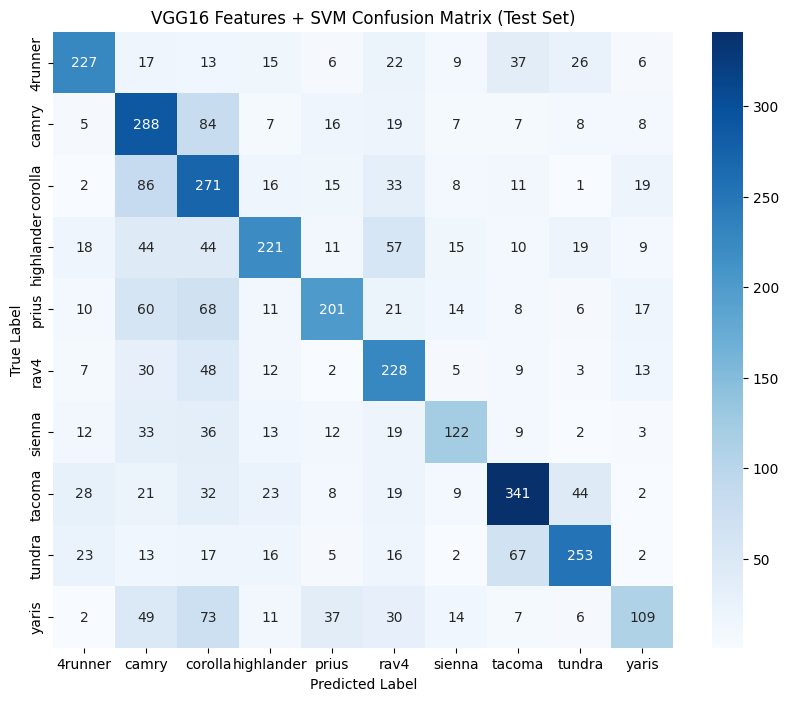

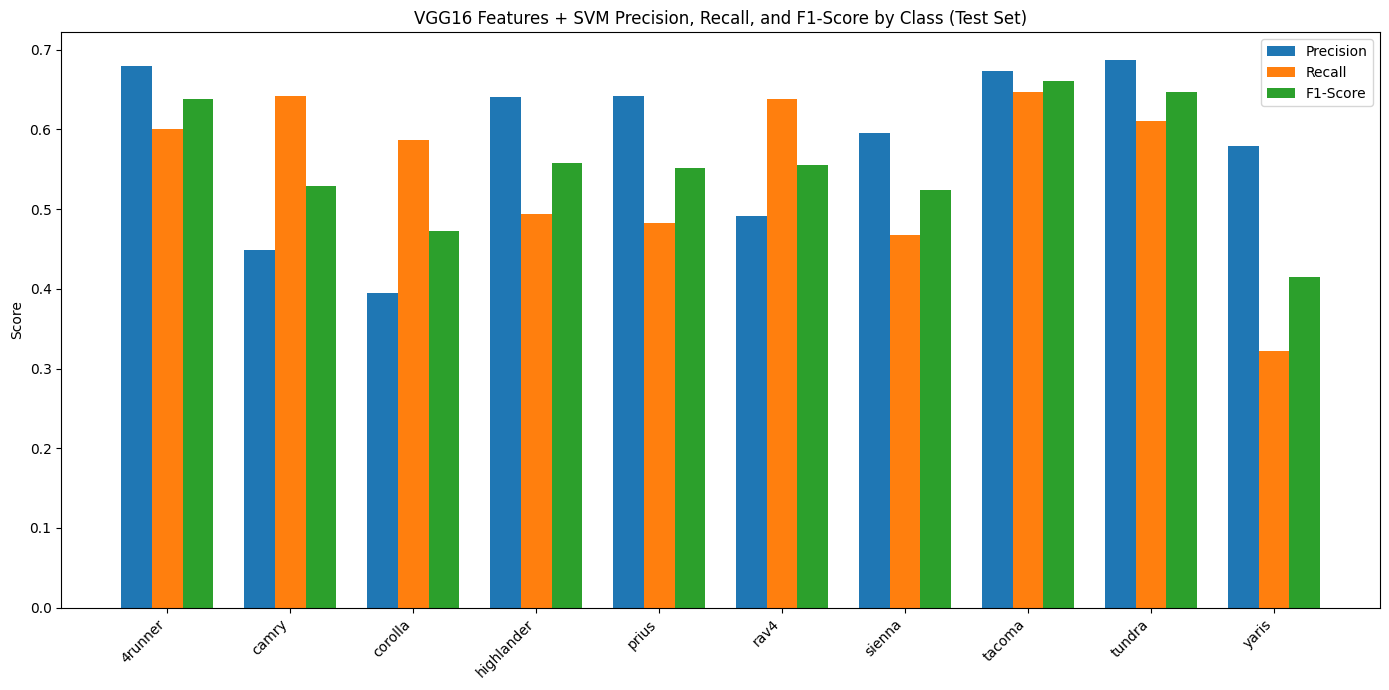


VGG16 Features + SVM Detailed Classification Report (Text Format, Test Set):
              precision    recall  f1-score   support

     4runner       0.68      0.60      0.64       378
       camry       0.45      0.64      0.53       449
     corolla       0.40      0.59      0.47       462
  highlander       0.64      0.49      0.56       448
       prius       0.64      0.48      0.55       416
        rav4       0.49      0.64      0.56       357
      sienna       0.60      0.47      0.52       261
      tacoma       0.67      0.65      0.66       527
      tundra       0.69      0.61      0.65       414
       yaris       0.58      0.32      0.41       338

    accuracy                           0.56      4050
   macro avg       0.58      0.55      0.55      4050
weighted avg       0.58      0.56      0.56      4050



In [ ]:
svm_predicted_labels_indices = svm_classifier.predict(test_features)

svm_cm = confusion_matrix(test_labels_indices, svm_predicted_labels_indices)

plt.figure(figsize=(10, 8))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('VGG16 Features + SVM Confusion Matrix (Test Set)')
plt.show()

svm_report = classification_report(test_labels_indices, svm_predicted_labels_indices, target_names=class_names, output_dict=True)

classes_svm = []
precision_scores_svm = []
recall_scores_svm = []
f1_scores_svm = []

for class_name, metrics in svm_report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        classes_svm.append(class_name)
        precision_scores_svm.append(metrics['precision'])
        recall_scores_svm.append(metrics['recall'])
        f1_scores_svm.append(metrics['f1-score'])

x_svm = np.arange(len(classes_svm))
width_svm = 0.25

fig_svm, ax_svm = plt.subplots(figsize=(14, 7))

rects1_svm = ax_svm.bar(x_svm - width_svm, precision_scores_svm, width_svm, label='Precision')
rects2_svm = ax_svm.bar(x_svm, recall_scores_svm, width_svm, label='Recall')
rects3_svm = ax_svm.bar(x_svm + width_svm, f1_scores_svm, width_svm, label='F1-Score')

ax_svm.set_ylabel('Score')
ax_svm.set_title('VGG16 Features + SVM Precision, Recall, and F1-Score by Class (Test Set)')
ax_svm.set_xticks(x_svm)
ax_svm.set_xticklabels(classes_svm, rotation=45, ha="right")
ax_svm.legend()

plt.tight_layout()
plt.show()

print("\nVGG16 Features + SVM Detailed Classification Report (Text Format, Test Set):")
print(classification_report(test_labels_indices, svm_predicted_labels_indices, target_names=class_names))